In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import control as ct

In [2]:
def vehicle_update(t, x, u, params={}):
    """Vehicle dynamics for cruise control system.

    Parameters
    ----------
    x : array
         System state: car velocity in m/s
    u : array
         System input: [throttle, gear, road_slope], where throttle is
         a float between 0 and 1, gear is an integer between 1 and 5,
         and road_slope is in rad.

    Returns
    -------
    float
        Vehicle acceleration

    """
    from math import copysign, sin
    sign = lambda x: copysign(1, x)         # define the sign() function

    # Set up the system parameters
    m = params.get('m', 1600.)              # vehicle mass, kg
    g = params.get('g', 9.8)                # gravitational constant, m/s^2
    Cr = params.get('Cr', 0.01)             # coefficient of rolling friction
    Cd = params.get('Cd', 0.32)             # drag coefficient
    rho = params.get('rho', 1.3)            # density of air, kg/m^3
    A = params.get('A', 2.4)                # car area, m^2
    alpha = params.get(
        'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

    # Define variables for vehicle state and inputs
    v = x[0]                           # vehicle velocity
    throttle = np.clip(u[0], 0, 1)     # vehicle throttle
    gear = u[1]                        # vehicle gear
    theta = u[2]                       # road slope

    # Force generated by the engine

    omega = alpha[int(gear)-1] * v      # engine angular speed
    F = alpha[int(gear)-1] * motor_torque(omega, params) * throttle

    # Disturbance forces
    #
    # The disturbance force Fd has three major components: Fg, the forces due
    # to gravity; Fr, the forces due to rolling friction; and Fa, the
    # aerodynamic drag.

    # Letting the slope of the road be \theta (theta), gravity gives the
    # force Fg = m g sin \theta.

    Fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
    # zero if v = 0.

    Fr  = m * g * Cr * sign(v)

    # The aerodynamic drag is proportional to the square of the speed: Fa =
    # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
    # shape-dependent aerodynamic drag coefficient, and A is the frontal area
    # of the car.

    Fa = 1/2 * rho * Cd * A * abs(v) * v

    # Final acceleration on the car
    Fd = Fg + Fr + Fa
    dv = (F - Fd) / m

    return dv

In [3]:
def motor_torque(omega, params={}):
    # Set up the system parameters
    Tm = params.get('Tm', 190.)             # engine torque constant
    omega_m = params.get('omega_m', 420.)   # peak engine angular speed
    beta = params.get('beta', 0.4)          # peak engine rolloff

    return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

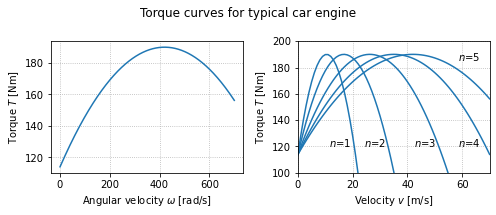

In [4]:
# Figure 4.2
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# (a) - single torque curve as function of omega
ax = axes[0]
omega = np.linspace(0, 700, 701)
ax.plot(omega, motor_torque(omega))
ax.set_xlabel(r'Angular velocity $\omega$ [rad/s]')
ax.set_ylabel('Torque $T$ [Nm]')
ax.grid(True, linestyle='dotted')

# (b) - torque curves in different gears, as function of velocity
ax = axes[1]
v = np.linspace(0, 70, 71)
alpha = [40, 25, 16, 12, 10]
for gear in range(5):
    omega = alpha[gear] * v
    T = motor_torque(omega)
    plt.plot(v, T, color='#1f77b4', linestyle='solid')

# Set up the axes and style
ax.axis([0, 70, 100, 200])
ax.grid(True, linestyle='dotted')

# Add labels
plt.text(11.5, 120, '$n$=1')
ax.text(24, 120, '$n$=2')
ax.text(42.5, 120, '$n$=3')
ax.text(58.5, 120, '$n$=4')
ax.text(58.5, 185, '$n$=5')
ax.set_xlabel('Velocity $v$ [m/s]')
ax.set_ylabel('Torque $T$ [Nm]')

plt.suptitle('Torque curves for typical car engine')
plt.tight_layout()

In [5]:
vehicle = ct.NonlinearIOSystem(
    vehicle_update, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

In [6]:
# Define a function for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, label=None, t_hill=None, vref=20, antiwindup=False,
                linetype='b-', subplots=None, legend=None):
    if subplots is None:
        subplots = [None, None]
    # Figure out the plot bounds and indices
    v_min = vref - 1.2; v_max = vref + 0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1

    # Create arrays for return values
    subplot_axes = list(subplots)

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--', label='t hill')
    plt.axis([0, t[-1], v_min, v_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Velocity $v$ [m/s]')

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype, label=label)
    # Applied input profile
    if antiwindup:
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype, label='Applied')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--')
    if legend:
        plt.legend(frameon=False)
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Throttle $u$')

    return subplot_axes

In [10]:
def sf_update(t, z, u, params={}):

    K = params.get('K', 0)
    ki = params.get('ki', 0)
    kf = params.get('kf', 0)
    xd = params.get('xd', 0)
    yd = params.get('yd', 0)
    ud = params.get('ud', 0)

    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return ud - K * (x - xd) - ki * z + kf * (r - yd)

In [11]:
# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, None, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))

# Create the closed loop system for the state space controller
cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Find the equilibrium point for the system
Xeq, Ueq = ct.find_eqpt(
    vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
print("Xeq = ", Xeq)
print("Ueq = ", Ueq)

# Compute the linearized system at the eq pt
cruise_linearized = ct.linearize(vehicle, Xeq, [Ueq[0], gear[0], 0])

Xeq =  [20.]
Ueq =  [0.16874874 4.         0.        ]


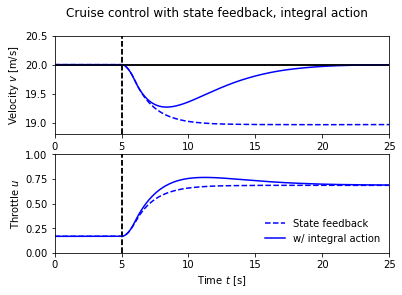

In [8]:
# Construct the gain matrices for the system
A, B, C = cruise_linearized.A, cruise_linearized.B[0, 0], cruise_linearized.C
K = 0.5
kf = -1 / (C * np.linalg.inv(A - B * K) * B)

# Compute the steady state velocity and throttle setting
xd = Xeq[0]
ud = Ueq[0]
yd = vref[-1]

# Response of the system with no integral feedback term
plt.figure()
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y_sfb = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.0, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y_sfb, t_hill=5, linetype='b--')

# Response of the system with state feedback + integral action
t, y_sfb_int = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b-', subplots=subplots)

# Add title and legend
plt.suptitle('Cruise control with state feedback, integral action')
import matplotlib.lines as mlines
p_line = mlines.Line2D([], [], color='blue', linestyle='--', label='State feedback')
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='w/ integral action')
plt.legend(handles=[p_line, pi_line], frameon=False, loc='lower right');